In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score,precision_score ,confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Data Cleaning and Formating

In [292]:
data = pd.read_csv (r'C:\Users\Legion\Python\Git\Project_Fraud\Synthetic_Financial_datasets_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [293]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [294]:
missing_values = data.isnull().sum()
missing_values    

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [295]:
# Convert class variables type to object
data['isFraud'] = data['isFraud'].astype('object')

In [296]:
# Summary Statistic
data.describe 


<bound method NDFrame.describe of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest isFraud  \
0             160296.36  M1979787155            0.00            0.00       0   
1

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


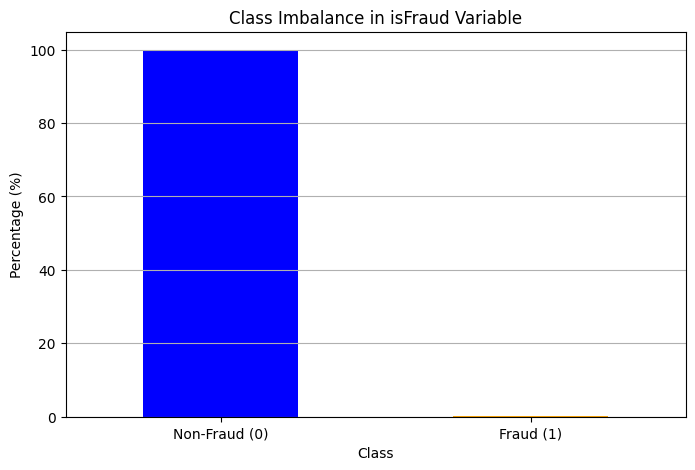

In [297]:
# Class Imbalance
# Calculate and plot class imbalance
class_imbalance = data['isFraud'].value_counts(normalize=True) * 100
class_imbalance.plot(kind='bar', color=['blue', 'orange'], figsize=(8, 5))

# Print class imbalance
print(class_imbalance)

# Customize plot
plt.title('Class Imbalance in isFraud Variable')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.grid(axis='y')
plt.show()

Only 0.13% (8,213) transactions in the dataset are fraudulent indicating high-class
imbalance in the dataset. This is important because if we build a machine learning model
on this highly skewed data, the non-fraudulent transactions will influence the training of
the model almost entirely, thus affecting the results.

Types of Transaction

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


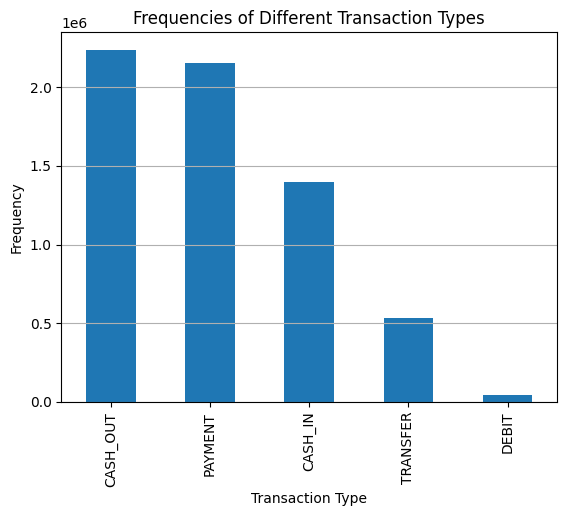

In [298]:
# Calculate frequencies of transaction types
transaction_frequencies = data['type'].value_counts()

# Print transaction frequencies
print(transaction_frequencies)

# Plotting the transaction frequencies
transaction_frequencies.plot(kind='bar')
plt.title('Frequencies of Different Transaction Types')
plt.xlabel('Transaction Type'), plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

type
CASH_IN          NaN
CASH_OUT    0.183955
DEBIT            NaN
PAYMENT          NaN
TRANSFER    0.768799
Name: count, dtype: float64


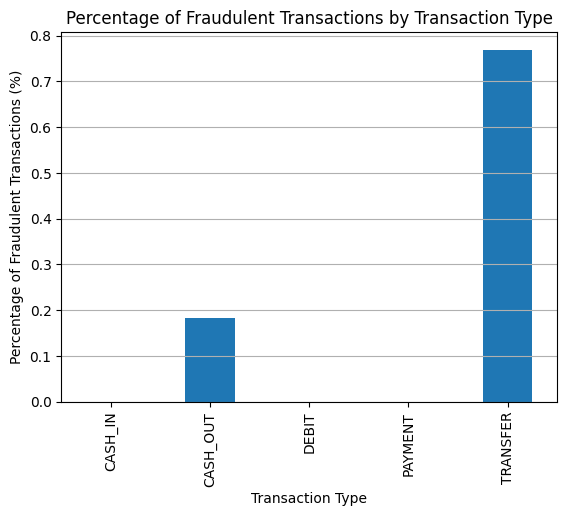

In [299]:
# Calculate total transactions and fraudulent transactions by type
total_transactions = data['type'].value_counts()
fraudulent_transactions = data[data['isFraud'] == 1]['type'].value_counts()

# Calculate percentage of fraudulent transactions by type
fraud_percentage = (fraudulent_transactions / total_transactions) * 100

# Print the percentage of fraudulent transactions
print(fraud_percentage)

# Plotting the percentage of fraudulent transactions
fraud_percentage.plot(kind='bar')
plt.title('Percentage of Fraudulent Transactions by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Percentage of Fraudulent Transactions (%)')
plt.grid(axis='y')
plt.show()


Only CASH-OUT and TRANSFER transactions can be fraudulent. So, it makes sense
to retain only these two types of transactions in our dataset.

In [300]:
# Retaining only CASH-OUT and TRANSFER transactions
data = data.loc[data['type'].isin(['CASH_OUT', 'TRANSFER']), :]

# Output the number of transactions remaining
print('The new data now has', len(data), 'transactions.')

The new data now has 2770409 transactions.


type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


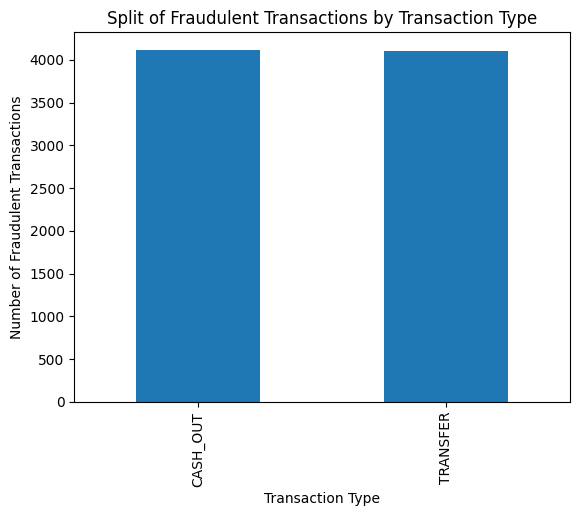

In [301]:
# Calculate the split of fraudulent transactions by transaction type
fraudulent_transactions = data[data['isFraud'] == 1]['type'].value_counts()

# Print the split of fraudulent transactions
print(fraudulent_transactions)

# Plotting the split of fraudulent transactions
fraudulent_transactions.plot(kind='bar')
plt.title('Split of Fraudulent Transactions by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

Both columns are  of the same length, Therefore, there is an almost equal likelihood that a fraudulent transaction can be
CASH_OUT or TRANSFER. 
Since only CASH-OUT and TRANSFER transactions can be fraudulent, we reduce the
size of the dataset by retaining only these transaction types and removing PAYMENT,
CASH-IN and DEBIT.

Data Sanity Checks

In [302]:
# Check for negative transaction amounts
negative_amount_count = (data['amount'] < 0).sum()
print('Number of transactions where the transaction amount is negative: ', negative_amount_count)

# Check for zero transaction amounts
zero_amount_count = (data['amount'] == 0).sum()
print('Number of transactions where the transaction amount is zero: ', zero_amount_count)

# Remove transactions with negative or zero amounts
data = data.loc[(data['amount'] > 0), :]

Number of transactions where the transaction amount is negative:  0
Number of transactions where the transaction amount is zero:  16


There are only a few cases in which transacted amount is 0. We observe by exploring the
data of these transactions that they are all fraudulent transactions. So, we can assume
that if the transaction amount is 0, the transaction is fraudulent.

In [303]:
# Calculate percentage of transactions where originator's initial balance is 0
originator_zero_balance_count = (data['oldbalanceOrg'] == 0).sum()
total_transactions = len(data)
originator_zero_balance_percentage = (originator_zero_balance_count / total_transactions) * 100

# Calculate percentage of transactions where destination's final balance is 0
destination_zero_balance_count = (data['newbalanceDest'] == 0).sum()
destination_zero_balance_percentage = (destination_zero_balance_count / total_transactions) * 100

# Output results
print(f"Percentage of transactions where originator's initial balance is 0: {originator_zero_balance_percentage:.2f}%")
print(f"Percentage of transactions where destination's final balance is 0: {destination_zero_balance_percentage:.2f}%")

Percentage of transactions where originator's initial balance is 0: 47.23%
Percentage of transactions where destination's final balance is 0: 0.60%


Therefore, in almost half of the transactions, the originator's initial balance was recorded
as 0. However, in less than 1% of cases, the recipient's final balance was recorded as 0.

In [304]:
# Calculate expected final balances for originator and recipient
data['expected_newbalanceOrig'] = data['oldbalanceOrg'] - data['amount']
data['expected_newbalanceDest'] = data['oldbalanceDest'] + data['amount']

# Check for incorrect balances
incorrect_originator_balances = (data['newbalanceOrig'] != data['expected_newbalanceOrig']).sum()
incorrect_recipient_balances = (data['newbalanceDest'] != data['expected_newbalanceDest']).sum()

# Calculate percentage of incorrect balances
total_transactions = len(data)
originator_inaccuracy_percentage = (incorrect_originator_balances / total_transactions) * 100
recipient_inaccuracy_percentage = (incorrect_recipient_balances / total_transactions) * 100

# Output results
print(f"Percentage of transactions where originator balances are not accurately captured: {originator_inaccuracy_percentage:.2f}%")
print(f"Percentage of transactions where destination balances are not accurately captured: {recipient_inaccuracy_percentage:.2f}%")

Percentage of transactions where originator balances are not accurately captured: 93.72%
Percentage of transactions where destination balances are not accurately captured: 42.09%


Therefore, in most transactions, the originator's final balance is not accurately captured,
and in almost half the cases, the recipient's final balance is not accurately captured.

FRAUD TRANSACTION ANALYSIS
an additional exploratory analysis is performed to identify if any of the variables can predict a fraud

C:\Users\Legion\AppData\Local\Temp\ipykernel_36148\3324696107.py:14: UserWarning: The palette list has more values (743) than needed (741), which may not be intended.
  sb.barplot(data=result[result['isFraud'] == 'Fraud'], x='step', y='count', ax=axes[0],hue ='step',legend=False, palette= colors)
C:\Users\Legion\AppData\Local\Temp\ipykernel_36148\3324696107.py:22: UserWarning: The palette list has more values (743) than needed (423), which may not be intended.
  sb.barplot(data=result[result['isFraud'] == 'Non-Fraud'], x='step', y='count', ax=axes[1], hue = 'step', legend = False, palette=colors)


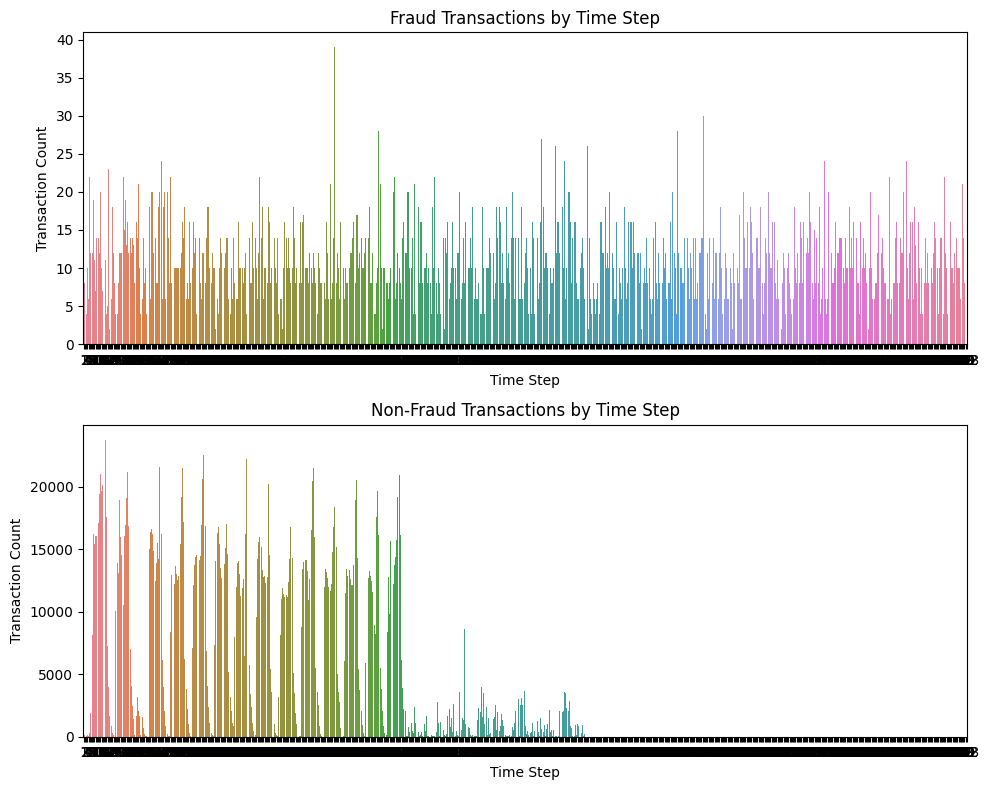

In [305]:
# Count fraud and non-fraud transactions by time step
result = data.groupby(['step', 'isFraud']).size().reset_index(name='count')

# Map isFraud to labels for better readability
result['isFraud'] = result['isFraud'].map({0: 'Non-Fraud', 1: 'Fraud'})

# Set up the figure and axes for a 2x1 grid
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Define a color palette
colors = sb.color_palette("husl", len(result['step'].unique()))

# Plot for Fraud Transactions
sb.barplot(data=result[result['isFraud'] == 'Fraud'], x='step', y='count', ax=axes[0],hue ='step',legend=False, palette= colors)
axes[0].set_title('Fraud Transactions by Time Step')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Transaction Count')
axes[0].set_xticks(range(len(result['step'].unique())))
axes[0].set_xticklabels(result['step'].unique(), rotation=0)

# Plot for Non-Fraud Transactions
sb.barplot(data=result[result['isFraud'] == 'Non-Fraud'], x='step', y='count', ax=axes[1], hue = 'step', legend = False, palette=colors)
axes[1].set_title('Non-Fraud Transactions by Time Step')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Transaction Count')
axes[1].set_xticks(range(len(result['step'].unique())))
axes[1].set_xticklabels(result['step'].unique(), rotation=0)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

the fraud transactions are almost uniformly spread out across time steps, whereas non-fraudulent transactions are more concentrated in specific time
steps. This could be a differentiator between the two categories and can help in the training of the classification models.

C:\Users\Legion\AppData\Local\Temp\ipykernel_36148\2289632119.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.stripplot(x='isFraud', y='amount', data=data, jitter=True, palette='Set2', size=0.5, alpha = 0.2)


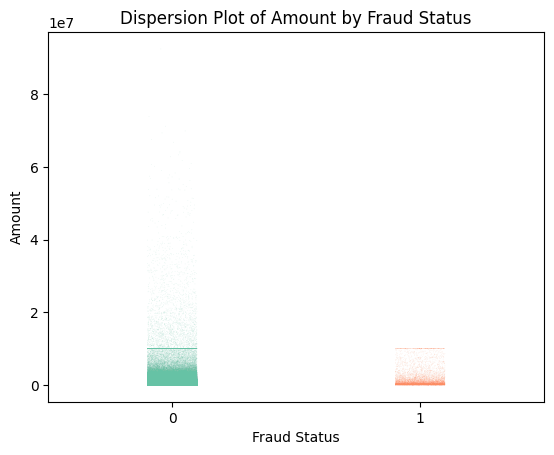

In [306]:
# Create a wider scatter plot
sb.stripplot(x='isFraud', y='amount', data=data, jitter=True, palette='Set2', size=0.5, alpha = 0.2)

# Adding titles and labels
plt.title('Dispersion Plot of Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Amount')

# Show the plot
plt.show()

The distribution of the transaction amount suggests that the amount can be slightly higher
for Non-Fraud transactions, but nothing can be said conclusively about differences Fraud
and Non-Fraud in terms of the transaction amount

In [307]:
#Comparison of fraud and non-fraud transactions where originator's initial balance is 0
# Filter transactions where oldbalanceOrg is 0
zero_balance_transactions = data[data['oldbalanceOrg'] == 0]

# Group by isFraud to compare fraud and non-fraud transactions
comparison = zero_balance_transactions.groupby('isFraud').agg(
    count=('amount', 'count'),
    average_amount=('amount', 'mean'),
    total_amount=('amount', 'sum')
).reset_index()

# Rename the isFraud column for clarity
comparison['isFraud'] = comparison['isFraud'].map({0: 'Non-Fraud', 1: 'Fraud'})

# Print the comparison
print(comparison)

     isFraud    count  average_amount  total_amount
0  Non-Fraud  1308541   333603.134009  4.365334e+11
1      Fraud       25   381402.827200  9.535071e+06


In [308]:
# Calculate total transactions
total_transactions = len(data)

# Calculate fraudulent transactions where oldbalanceOrg is 0
fraudulent_with_zero_balance = data[(data['isFraud'] == 1) & (data['oldbalanceOrg'] == 0)]
percentage_fraudulent_zero_balance = (len(fraudulent_with_zero_balance) / total_transactions) * 100

# Calculate genuine transactions where oldbalanceOrg is 0
genuine_with_zero_balance = data[(data['isFraud'] == 0) & (data['oldbalanceOrg'] == 0)]
percentage_genuine_zero_balance = (len(genuine_with_zero_balance) / total_transactions) * 100

# Print results
print(f"% of fraudulent transactions where initial balance of originator is 0: {percentage_fraudulent_zero_balance:.2f}%")
print(f"% of genuine transactions where initial balance of originator is 0: {percentage_genuine_zero_balance:.2f}%")

% of fraudulent transactions where initial balance of originator is 0: 0.00%
% of genuine transactions where initial balance of originator is 0: 47.23%


In fraudulent transactions, originator’s initial balance is 0 in 0.0% of the time as compared to 47% in case of non-fraudulent transactions.
 This could be another potential differentiator between the two categories.

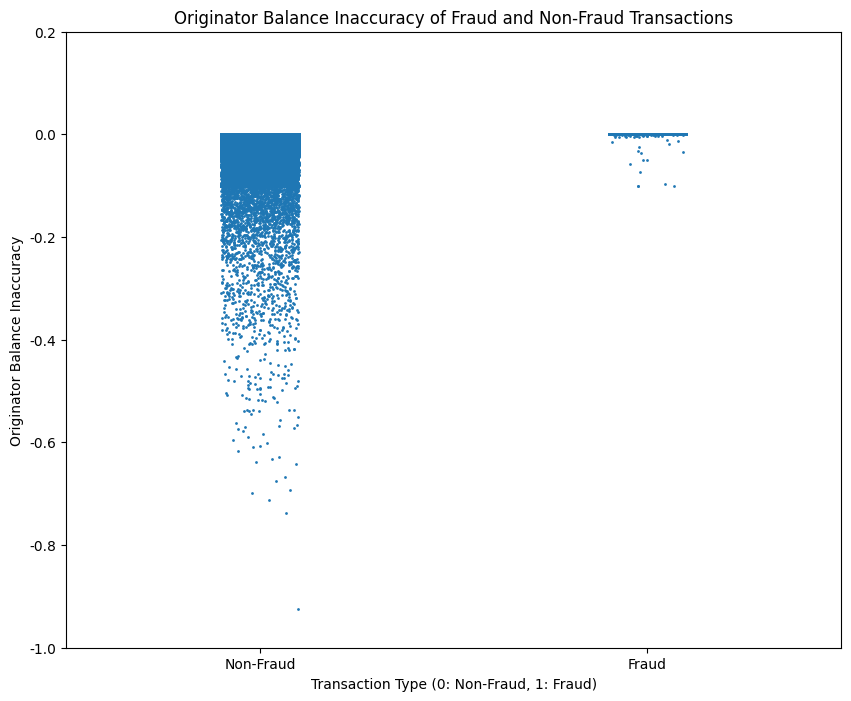

In [309]:
# Define inaccuracies in originator balances
data['origBalance_inacc'] = (data['oldbalanceOrg'] - data['amount']) - data['newbalanceOrig']

plt.figure(figsize=(10, 8))
sb.stripplot(data=data, x='isFraud', y='origBalance_inacc',size=2, dodge=True, jitter=True)


# Set y-ticks to reflect scale of 1e8
plt.yticks(ticks=plt.yticks()[0], labels=[f"{tick / 1e8:.1f}" for tick in plt.yticks()[0]])

# Customize the plot
plt.title('Originator Balance Inaccuracy of Fraud and Non-Fraud Transactions')
plt.xlabel('Transaction Type (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Originator Balance Inaccuracy')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()

c:\Users\Legion\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


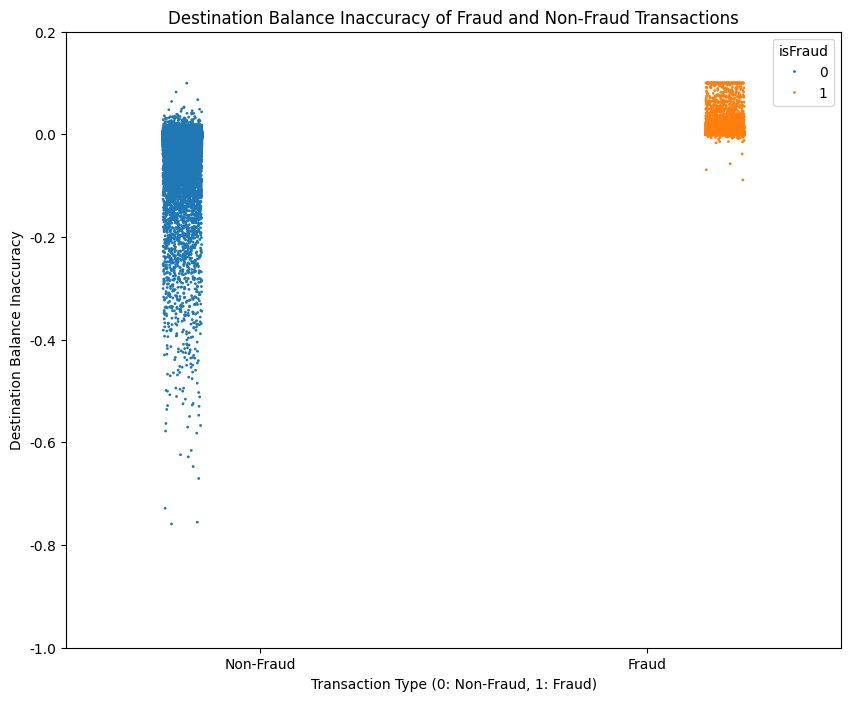

In [310]:
# Calculate destination balance inaccuracies
data['destBalance_inacc'] = (data['oldbalanceDest'] + data['amount']) - data['newbalanceDest']

# Create a strip plot
plt.figure(figsize=(10, 8))

sb.stripplot(data=data, x='isFraud', y='destBalance_inacc', size=2, hue='isFraud', dodge=True, jitter=True)

# Customize the plot
plt.title('Destination Balance Inaccuracy of Fraud and Non-Fraud Transactions')
plt.xlabel('Transaction Type (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Destination Balance Inaccuracy')

# Set y-ticks to reflect scale of 1e8
plt.yticks(ticks=plt.yticks()[0], labels=[f"{tick / 1e8:.1f}" for tick in plt.yticks()[0]])

plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'])
plt.show()

it appears that the inaccuracy in destination balance is almost always negative for non-fraud transactions, 
whereas it is almost always positive for fraud transactions.
This could also be potential predictors of fraud

we identified a few dimensions along which fraudulent transactions can be distinguished from non-fraudulent transactions. These are as follows:
 time step - fraudulent transactions have are equally likely to occur in all time steps, but genuine transactions peak in specific time steps

 balances - initial balance of originator is much more likely to be 0 in case of genuine transactions than fraud transactions

 inaccuracies in balance - inaccuracy in destination balance is likely to be negative in case of genuine transactions but positive in case of fraud transactions

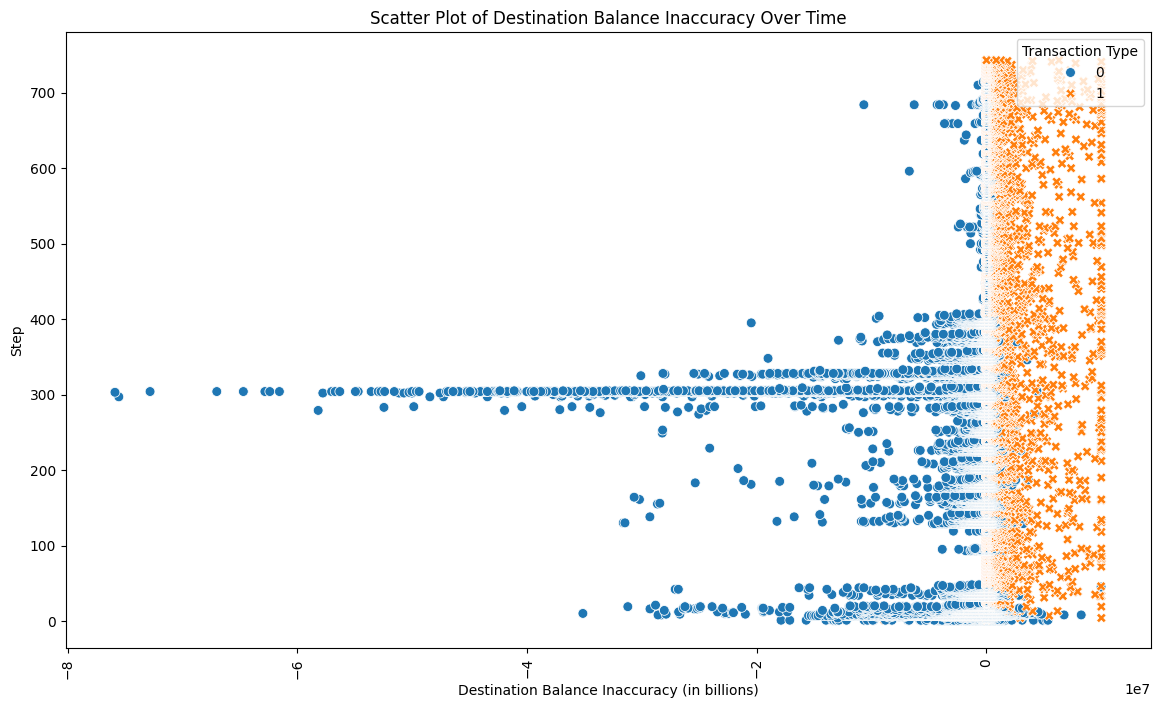

In [311]:
# Separation between Fraud and Non-Fraud Transactions
# Create a scatter plot
plt.figure(figsize=(14, 8))
sb.scatterplot(data=data, x='destBalance_inacc',y='step', hue='isFraud', style='isFraud', markers={0: 'o', 1: 'X'}, s=50)

# Customize the plot
plt.title('Scatter Plot of Destination Balance Inaccuracy Over Time')
plt.ylabel('Step')
plt.xlabel('Destination Balance Inaccuracy (in billions)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Transaction Type', loc='upper right')

# Show the plot
plt.show()

Predictive Modeling for Fraud Detection
we identified dimensions that make fraudulent transactions detectable.
Based on these results, we build supervised classification models.

Modeling Dataset Creation

In [312]:
# Removing name columns
data = data.drop(['nameOrig', 'nameDest'], axis=1)

# Convert the 'isFraud' column from object to int
data['isFraud'] = data['isFraud'].astype(int)

Creating dummy variables

In [313]:
# Creating dummy variables through one hot encoding for 'type' column
data = pd.get_dummies(data, columns=['type'], prefix=['type'])
data.tail()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,expected_newbalanceOrig,expected_newbalanceDest,origBalance_inacc,destBalance_inacc,type_CASH_OUT,type_TRANSFER
6362615,743,339682.13,339682.13,0.0,0.00,339682.13,1,0,0.0,339682.13,0.0,0.000000e+00,True,False
6362616,743,6311409.28,6311409.28,0.0,0.00,0.00,1,0,0.0,6311409.28,0.0,6.311409e+06,False,True
6362617,743,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0,0.0,6379898.12,0.0,1.000000e-02,True,False
6362618,743,850002.52,850002.52,0.0,0.00,0.00,1,0,0.0,850002.52,0.0,8.500025e+05,False,True
6362619,743,850002.52,850002.52,0.0,6510099.11,7360101.63,1,0,0.0,7360101.63,0.0,9.313226e-10,True,False


Standardizing the data

In [314]:
# Normalization of the dataset
# Initialize StandardScaler
std_scaler = StandardScaler()

# Apply scaling to the dataset, excluding the 'isFraud' column
data_scaled = pd.DataFrame(std_scaler.fit_transform(data.loc[:, data.columns != 'isFraud']),
                            columns=data.columns[data.columns != 'isFraud'],
                            index=data.index)

# Add the 'isFraud' column back to the scaled DataFrame
data_scaled['isFraud'] = data['isFraud'].values

# Display the scaled DataFrame
print(data_scaled)

             step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2       -1.701817 -0.357468      -0.188848       -0.106389       -0.403155   
3       -1.701817 -0.357468      -0.188848       -0.106389       -0.398142   
15      -1.701817 -0.099577      -0.128591       -0.106389       -0.401952   
19      -1.701817 -0.115148      -0.186763       -0.106389       -0.397848   
24      -1.701817 -0.006592      -0.146457       -0.106389       -0.401672   
...           ...       ...            ...             ...             ...   
6362615  3.537664  0.024943       1.161993       -0.106389       -0.403155   
6362616  3.537664  6.751439      24.922894       -0.106389       -0.403155   
6362617  3.537664  6.751439      24.922894       -0.106389       -0.386947   
6362618  3.537664  0.599763       3.192506       -0.106389       -0.403155   
6362619  3.537664  0.599763       3.192506       -0.106389        1.137493   

         newbalanceDest  isFlaggedFraud  expected_newbalanceOri

Create train and test datasets

In [315]:
# Train-test split
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.3, random_state=0)

# Label Encoding
label_encoder = LabelEncoder()
y_train_original = label_encoder.fit_transform(y_train_original.values.ravel())
y_test_original = label_encoder.transform(y_test_original.values.ravel()) 

In [316]:
# Class Imbalance in train and test Datasets
# Assuming data_scaled is your DataFrame containing the features and the target variable
X = data_scaled.loc[:, data_scaled.columns != 'isFraud']
y = data_scaled['isFraud']  # Directly use the 'isFraud' column

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Calculate class distribution in the training set
train_class_distribution = y_train.value_counts(normalize=True) * 100
print("Class distribution in training set (%):")
print(train_class_distribution)

# Calculate class distribution in the test set
test_class_distribution = y_test.value_counts(normalize=True) * 100
print("\nClass distribution in test set (%):")
print(test_class_distribution)

# Calculate the percentage of fraud transactions in both datasets
train_fraud_percentage = train_class_distribution.get(1, 0)  # Assuming '1' is the fraud class
test_fraud_percentage = test_class_distribution.get(1, 0)    # Assuming '1' is the fraud class

print(f"\nClass imbalance in train dataset: {train_fraud_percentage:.3f}%")
print(f"Class imbalance in test dataset: {test_fraud_percentage:.3f}%")


Class distribution in training set (%):
isFraud
0    99.704219
1     0.295781
Name: proportion, dtype: float64

Class distribution in test set (%):
isFraud
0    99.703893
1     0.296107
Name: proportion, dtype: float64

Class imbalance in train dataset: 0.296%
Class imbalance in test dataset: 0.296%


Classification Models for Fraud detection
- perform the classification: Logistic Regression and Random Forest

In [317]:
# Defining Logistic Regression and Random Forest Models
scr = 'recall'
accuracy_dict = {}
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()
skf = StratifiedKFold(5) # for cross validation

Logistic Regression Model

Logistic Regression's average recall score across validation sets is: 50.24%
Logistic Regression's average precision score across validation sets is: 90.68%


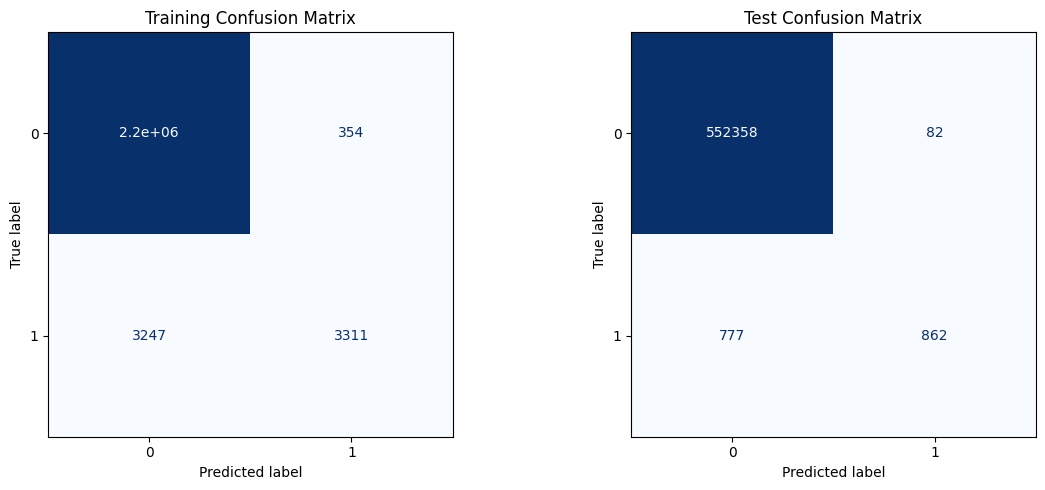

Training Recall: 50.49%
Training Precision: 90.34%
Test Recall: 52.59%
Test Precision: 91.31%


In [326]:
# Model setup with parameters
model_lr = LogisticRegression(C=1.0, solver='lbfgs', random_state=42)

# Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scorers
recall_scorer = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)

# Cross-validation for recall score
recall_scores = cross_val_score(model_lr, X_train_original, y_train_original, cv=skf, scoring=recall_scorer)
average_recall = recall_scores.mean() * 100  # Convert to percentage

# Cross-validation for precision
precision_scores = cross_val_score(model_lr, X_train_original, y_train_original, cv=skf, scoring=precision_scorer)
average_precision = precision_scores.mean() * 100  # Convert to percentage

# Display average recall and precision
print("Logistic Regression's average recall score across validation sets is: {:.2f}%".format(average_recall))
print("Logistic Regression's average precision score across validation sets is: {:.2f}%".format(average_precision))

# Fit the model on the scaled training data
model_lr.fit(X_train_original, y_train_original)

# Make predictions on the scaled test set
y_test_pred = model_lr.predict(X_test_original)

# Compute confusion matrices
cm_train = confusion_matrix(y_train_original, model_lr.predict(X_train_original))
cm_test = confusion_matrix(y_test_original, y_test_pred)

# Display the confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title('Training Confusion Matrix')

# Test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
axes[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

# Calculate and display final metrics for both datasets
train_recall = recall_score(y_train_original, model_lr.predict(X_train_original)) * 100
train_precision = precision_score(y_train_original, model_lr.predict(X_train_original)) * 100
test_recall = recall_score(y_test_original, y_test_pred) * 100
test_precision = precision_score(y_test_original, y_test_pred) * 100

print("Training Recall: {:.2f}%".format(train_recall))
print("Training Precision: {:.2f}%".format(train_precision))
print("Test Recall: {:.2f}%".format(test_recall))
print("Test Precision: {:.2f}%".format(test_precision))


High Accuracy: The accuracy values (approximately 99.84%) suggest that the model is very good at predicting the majority class. This could be due to class imbalance, where the number of non-fraud cases far exceeds fraud cases.

Low Recall: A recall of 50.57% indicates that the model is only capturing about half of the actual fraud cases. This is critical, especially in fraud detection, where false negatives (failing to identify fraud) can have significant consequences.

Random Forest Model Training

Random Forest's average recall score across validation sets is: 99.57%
Random Forest's average precision score across validation sets is: 99.98%
Cross-validation accuracy scores: [0.99998646 0.99998872 0.99998872 0.99999098 0.9999797 ]
Mean accuracy: 0.9999869152082154
Test set precision score: 100.00%
Test set recall score: 99.63%


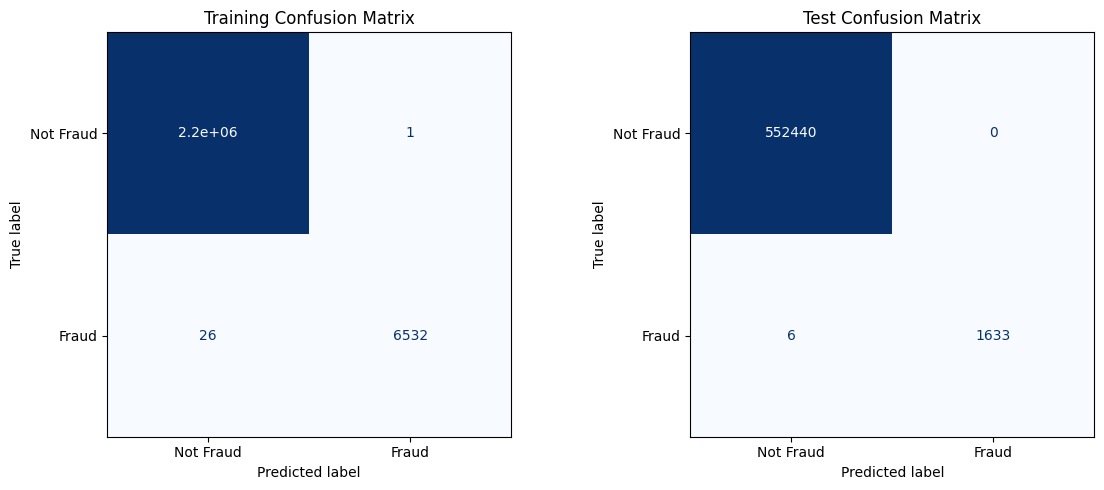

In [328]:
# Split the data into training and testing sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model setup for Random Forest with performance optimizations
model_rf = RandomForestClassifier(
    n_estimators=50,      # Reduce the number of trees
    max_depth=10,         # Limit the depth of each tree
    min_samples_split=5,  # Minimum samples to split an internal node
    min_samples_leaf=2,   # Minimum samples at a leaf node
    n_jobs=-1,            # Use all available cores
    random_state=42
)

# Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scorers
recall_scorer = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)

# Cross-validation for recall score
recall_scores = cross_val_score(model_rf, X_train_original, y_train_original, cv=skf, scoring=recall_scorer)
average_recall = recall_scores.mean() * 100  # Convert to percentage
print("Random Forest's average recall score across validation sets is: {:.2f}%".format(average_recall))

# Cross-validation for precision score
precision_scores = cross_val_score(model_rf, X_train_original, y_train_original, cv=skf, scoring=precision_scorer)
average_precision = precision_scores.mean() * 100  # Convert to percentage
print("Random Forest's average precision score across validation sets is: {:.2f}%".format(average_precision))

# Cross-validation for accuracy
accuracy_scores = cross_val_score(model_rf, X_train_original, y_train_original, cv=skf, scoring='accuracy')
print("Cross-validation accuracy scores:", accuracy_scores)
print("Mean accuracy:", accuracy_scores.mean())

# Fit the model on the training data
model_rf.fit(X_train_original, y_train_original)

# Make predictions on the test set
y_test_pred = model_rf.predict(X_test_original)

# Compute precision and recall for the test set
test_precision = precision_score(y_test_original, y_test_pred) * 100  # Convert to percentage
test_recall = recall_score(y_test_original, y_test_pred) * 100  # Convert to percentage
print("Test set precision score: {:.2f}%".format(test_precision))
print("Test set recall score: {:.2f}%".format(test_recall))

# Compute confusion matrices
cm_train = confusion_matrix(y_train_original, model_rf.predict(X_train_original))
cm_test = confusion_matrix(y_test_original, y_test_pred)

# Plotting confusion matrices in a single row with two columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["Not Fraud", "Fraud"])
disp_train.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title('Training Confusion Matrix')

# Test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Not Fraud", "Fraud"])
disp_test.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
axes[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

The Random Forest algorithm gives almost perfect results. Comparing the recall scores with Logistic Regression, 
Random Forest performs much better in detecting fraud.

Also, the performance of the Random Forest model is consistent between the training
and testing datasets. So, there is no overfitting.

In [331]:
# Create a DataFrame with the results
data = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Train Precision": [90.34, 99.98],
    "Train Recall": [50.49, 99.57],
    "Test Precision": [91.31, 100],
    "Test Recall": [52.59, 99.63]
}

results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df.to_string(index=False))

              Model  Train Precision  Train Recall  Test Precision  Test Recall
Logistic Regression            90.34         50.49           91.31        52.59
      Random Forest            99.98         99.57          100.00        99.63


Regardless of the positive results from the Random Forest model, we should try to improve the results of Logistic Regression 
through parameter tuning and by addressing  the class imbalance issue.

Addressing Class Imbalance
Train the Logistic Regression model on a subset of the original training dataset. 
We retain all the fraud cases and randomly select an equal number of non-fraud cases to create an undersampled training dataset.

In [332]:
# UnderSampling the Training Dataset

# Identifying indices for fraud and non-fraud cases
fraud_indices_train = np.where(y_train_original == 1)[0]
non_fraud_indices_train = np.where(y_train_original == 0)[0]

# Undersample non-fraud cases to match the number of fraud cases
undersample_non_fraud_indices_train = np.random.choice(non_fraud_indices_train, len(fraud_indices_train), replace=False)

# Combine the indices of fraud and undersampled non-fraud cases
undersample_indices_train = np.concatenate([fraud_indices_train, undersample_non_fraud_indices_train])

# Create the undersampled training dataset
X_train_undersample = X_train_original.iloc[undersample_indices_train, :]
y_train_undersample = y_train_original.iloc[undersample_indices_train]

# Optional: Reset the index of the undersampled dataset
X_train_undersample.reset_index(drop=True, inplace=True)
y_train_undersample.reset_index(drop=True, inplace=True)

# Display the shapes of the new datasets
print("Undersampled X shape:", X_train_undersample.shape)
print("Undersampled y shape:", y_train_undersample.shape)

Undersampled X shape: (13116, 13)
Undersampled y shape: (13116,)


Logistic Regression Parameter Tuning:
Identify the best Logistic Regression model for the undersampled dataset by
tuning the 'Cost function' and 'Regularization factor' parameters.

In [334]:
# Create the Logistic Regression model
model_lr = LogisticRegression(solver='liblinear')  # Use 'liblinear' for l1 regularization support

# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],          # Regularization penalties
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strengths
}

# Define the scorer
recall_scorer = make_scorer(recall_score)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model_lr, 
                           param_grid=param_grid, 
                           scoring=recall_scorer, 
                           cv=5, 
                           n_jobs=-1)  # Use all available cores

# Fit GridSearchCV to the undersampled dataset
grid_search.fit(X_train_undersample, y_train_undersample)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_recall = grid_search.best_score_

# Display the results
print("Best Parameters: ", best_params)
print("Best Recall Score: {:.2f}%".format(best_recall * 100))

Best Parameters:  {'C': 100, 'penalty': 'l2'}
Best Recall Score: 94.94%


As we can see after undersampling Recall Score improved greatly from 50% to 94%. But it still not able to beat Random Forest Model.
The default random forest model performs better than logistic regression model.

In [335]:
# Parameters of the best fit Random Forest Model

# Create the Random Forest model
model_rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],        # Number of trees
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]          # Minimum samples required to be at a leaf node
}

# Define the scorer
recall_scorer_rf = make_scorer(recall_score)

# Set up GridSearchCV
grid_search_rf = GridSearchCV(estimator=model_rf, 
                               param_grid=param_grid_rf, 
                               scoring=recall_scorer_rf, 
                               cv=5, 
                               n_jobs=-1)  # Use all available cores

# Fit GridSearchCV to the undersampled dataset
grid_search_rf.fit(X_train_undersample, y_train_undersample)

# Get the best parameters and best score
best_params_rf = grid_search_rf.best_params_
best_recall_rf = grid_search_rf.best_score_

# Display the results
print("Best Parameters for Random Forest: ", best_params_rf)
print("Best Recall Score: {:.2f}%".format(best_recall_rf * 100))

Best Parameters for Random Forest:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Recall Score: 99.62%


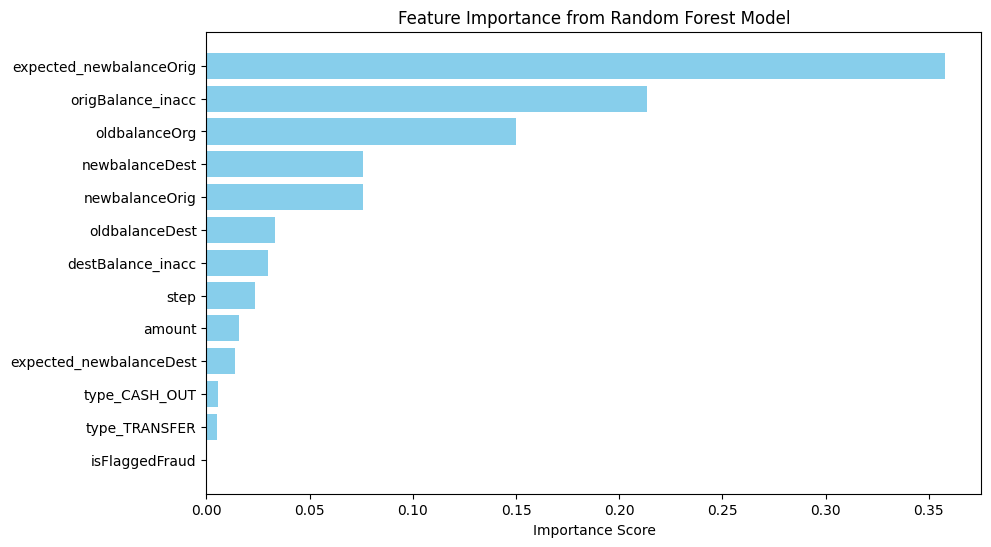

                    Feature  Importance
7   expected_newbalanceOrig    0.357665
9         origBalance_inacc    0.213555
2             oldbalanceOrg    0.149944
5            newbalanceDest    0.076075
3            newbalanceOrig    0.075812
4            oldbalanceDest    0.032994
10        destBalance_inacc    0.029970
0                      step    0.023429
1                    amount    0.015630
8   expected_newbalanceDest    0.013826
11            type_CASH_OUT    0.005825
12            type_TRANSFER    0.005036
6            isFlaggedFraud    0.000238


In [337]:
# Already fitted your Random Forest model and have the best estimator
best_rf_model = grid_search_rf.best_estimator_

# Get feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame for feature importances
features = X_train_undersample.columns  # Replace with your feature names
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# Display the DataFrame of feature importances
print(importance_df)

Therefore, the balance of the originator (“expected_newbalanceOrig”) feature is critical to making the prediction as compared to all other variables.

ROC curve of Random Forest Model

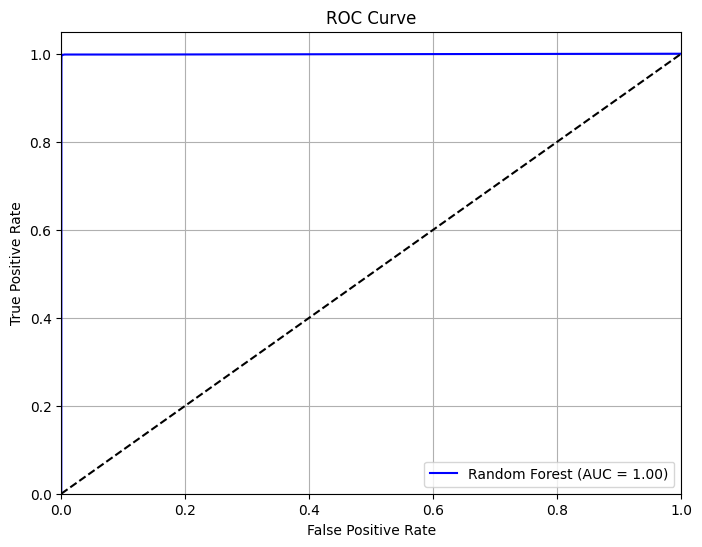

In [339]:
#Get predicted probabilities for the positive class
y_probs = best_rf_model.predict_proba(X_test_original)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_original, y_probs)

# Compute AUC
auc_score = roc_auc_score(y_test_original, y_probs)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Analysis Summary

We analyzed the financial transactions data and developed a machine learning model to detect fraud. 
The analysis included data cleaning, exploratory analysis and predictive modeling.

In the data cleaning, we checked for missing values, converted data types and summarized the variables in the data. 
In an exploratory analysis, we looked at the class imbalance, and deep-dived into each of the variables, in particular transaction type, transaction amount, balance and time step. We identified derived variables that can help with fraud detection. We also plotted various graphs to better visualize the data and come up with insights.

In predictive modeling, we experimented with Logistic Regression and Random Forest algorithms. We observed that Random Forest performs best for this application with almost 100% precision and recall scores. We tried to improve the logistic regression results by undersampling, but the results were the same because of a lot of the data is excluded. We ensured that there is no overfitting in the models through cross-validation. We can conclude that fraud detection in financial transactions is successful in this labeled
dataset, and the best algorithm for this purpose is Random Forest.